<a href="https://colab.research.google.com/github/iceman67/-Python/blob/master/PM25_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras.layers import Input
from keras.layers.core import Dense
from keras.models import Sequential
from keras.models import Model
from keras import regularizers
from keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [0]:
#!wget https://github.com/iceman67/HRS/blob/master/April_sensor_data.csv

In [0]:
# read in that strange European CSV data, semi-colon separated, with commas for decimal points
aqdf = pd.read_csv("April_sensor_data.csv")

In [64]:
aqdf.columns

Index(['NO', 'REG_DATE', 'PM2.5', 'PM10.0', 'Temperature', 'Huminity', 'TVOC',
       'CO2'],
      dtype='object')

In [0]:
aqdf = aqdf.rename(columns={'Huminity': 'Humidity', 'PM2.5' :'PM25', 'PM10.0':'PM100'})

In [0]:
aqdf.drop('NO', axis=1, inplace=True)
aqdf.drop('REG_DATE', axis=1, inplace=True)
#aqdf.drop('PM2.5', axis=1, inplace=True)
#aqdf.drop('PM10.0', axis=1, inplace=True)
aqdf.drop('Temperature', axis=1, inplace=True)
aqdf.drop('TVOC', axis=1, inplace=True)
aqdf.drop('Humidity', axis=1, inplace=True)
aqdf.drop('CO2', axis=1, inplace=True)


The standard score of a sample x is calculated as:

z = (x - u) / s

Standardization of a dataset is a common requirement for many machine learning estimators.  

StandardScaler(x), 평균이 0과 표준편차가 1이 되도록 변환

https://datascienceschool.net/view-notebook/f43be7d6515b48c0beb909826993c856/


In [0]:
#scaler =MinMaxScaler()
scaler = StandardScaler()
x_scaled = scaler.fit_transform(aqdf)

In [0]:
x_means = scaler.mean_
x_stds = scaler.scale_

In [69]:
x_means

array([13.8635544, 13.8726821])

In [70]:
x_stds

array([8.07562686, 7.59808376])

In [71]:
x_scaled[0]

array([-0.78304192, -1.01113417])

In [72]:
x_scaled.shape

(25920, 2)

In [0]:
y = x_scaled[:, 0]                  # y is  CO2 column - the target

In [74]:
y

array([-0.78304192, -0.7471314 , -0.78304192, ..., -1.08890053,
       -1.23378093, -1.14214717])

In [0]:
x = np.delete(x_scaled, 0, axis=1)  # x is everything else - the input

In [76]:
x.shape

(25920, 1)

In [77]:
x_stds[0]

8.075626862954957

In [78]:
x_means[0]

13.863554398148148

In [0]:
train_size = int(0.7 * x.shape[0])

In [0]:
x_train, x_test, y_train, y_test = x[0:train_size], x[train_size:], y[0:train_size], y[train_size:]

A dense layer represents a matrix vector multiplication.

Glorot Uniform initializer for the kernel weight matrix
It pulls values from a uniform distribution, however, its limits are dynamic 
with the size of the Dense layer

if the input shape is (1,) and number of unit is 8, then the output shape is (8,).


In [0]:
# regression network with 1 features -> 8 latent space -> 1 output

readings = Input(shape=(1, ))
encoded = Dense(8, activation='relu', kernel_initializer='glorot_uniform')(readings)
decoded = Dense(1, kernel_initializer='glorot_uniform')(encoded)
model = Model(inputs=[readings], outputs=[decoded])

model.compile(loss='mse', optimizer='adam')

In [82]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 16        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


In [83]:
my_epochs = 50

my_batch_size = 10
history = model.fit(x_train, y_train, batch_size=my_batch_size, epochs=my_epochs, validation_split=0.2)
y_test_pred = model.predict(x_test).flatten()

# Look at the results
restore_PM25 = lambda m: (m * x_stds[0]) + x_means[0]

for i in range(10):
    label = restore_PM25(y_test[i])
    prediction = restore_PM25(y_test_pred[i])
    print("PM 2.5 expected: {:.3f}, predicted: {:.3f}".format(label, prediction))



14515/14515 [==============================] - 1s 102us/step - loss: 0.0502 - val_loss: 0.0435
Epoch 12/50
14515/14515 [==============================] - 2s 105us/step - loss: 0.0503 - val_loss: 0.0450
Epoch 13/50
14515/14515 [==============================] - 1s 103us/step - loss: 0.0503 - val_loss: 0.0435
Epoch 14/50
14515/14515 [==============================] - 2s 105us/step - loss: 0.0503 - val_loss: 0.0450
Epoch 15/50
14515/14515 [==============================] - 1s 101us/step - loss: 0.0503 - val_loss: 0.0440
Epoch 16/50
14515/14515 [==============================] - 1s 100us/step - loss: 0.0503 - val_loss: 0.0436
Epoch 17/50
14515/14515 [==============================] - 1s 101us/step - loss: 0.0503 - val_loss: 0.0438
Epoch 18/50
14515/14515 [==============================] - 1s 101us/step - loss: 0.0503 - val_loss: 0.0439
Epoch 19/50
14515/14515 [==============================] - 1s 103us/step - loss: 0.0502 - val_loss: 0.0447
Epoch 20/50
14515/14515 [========================

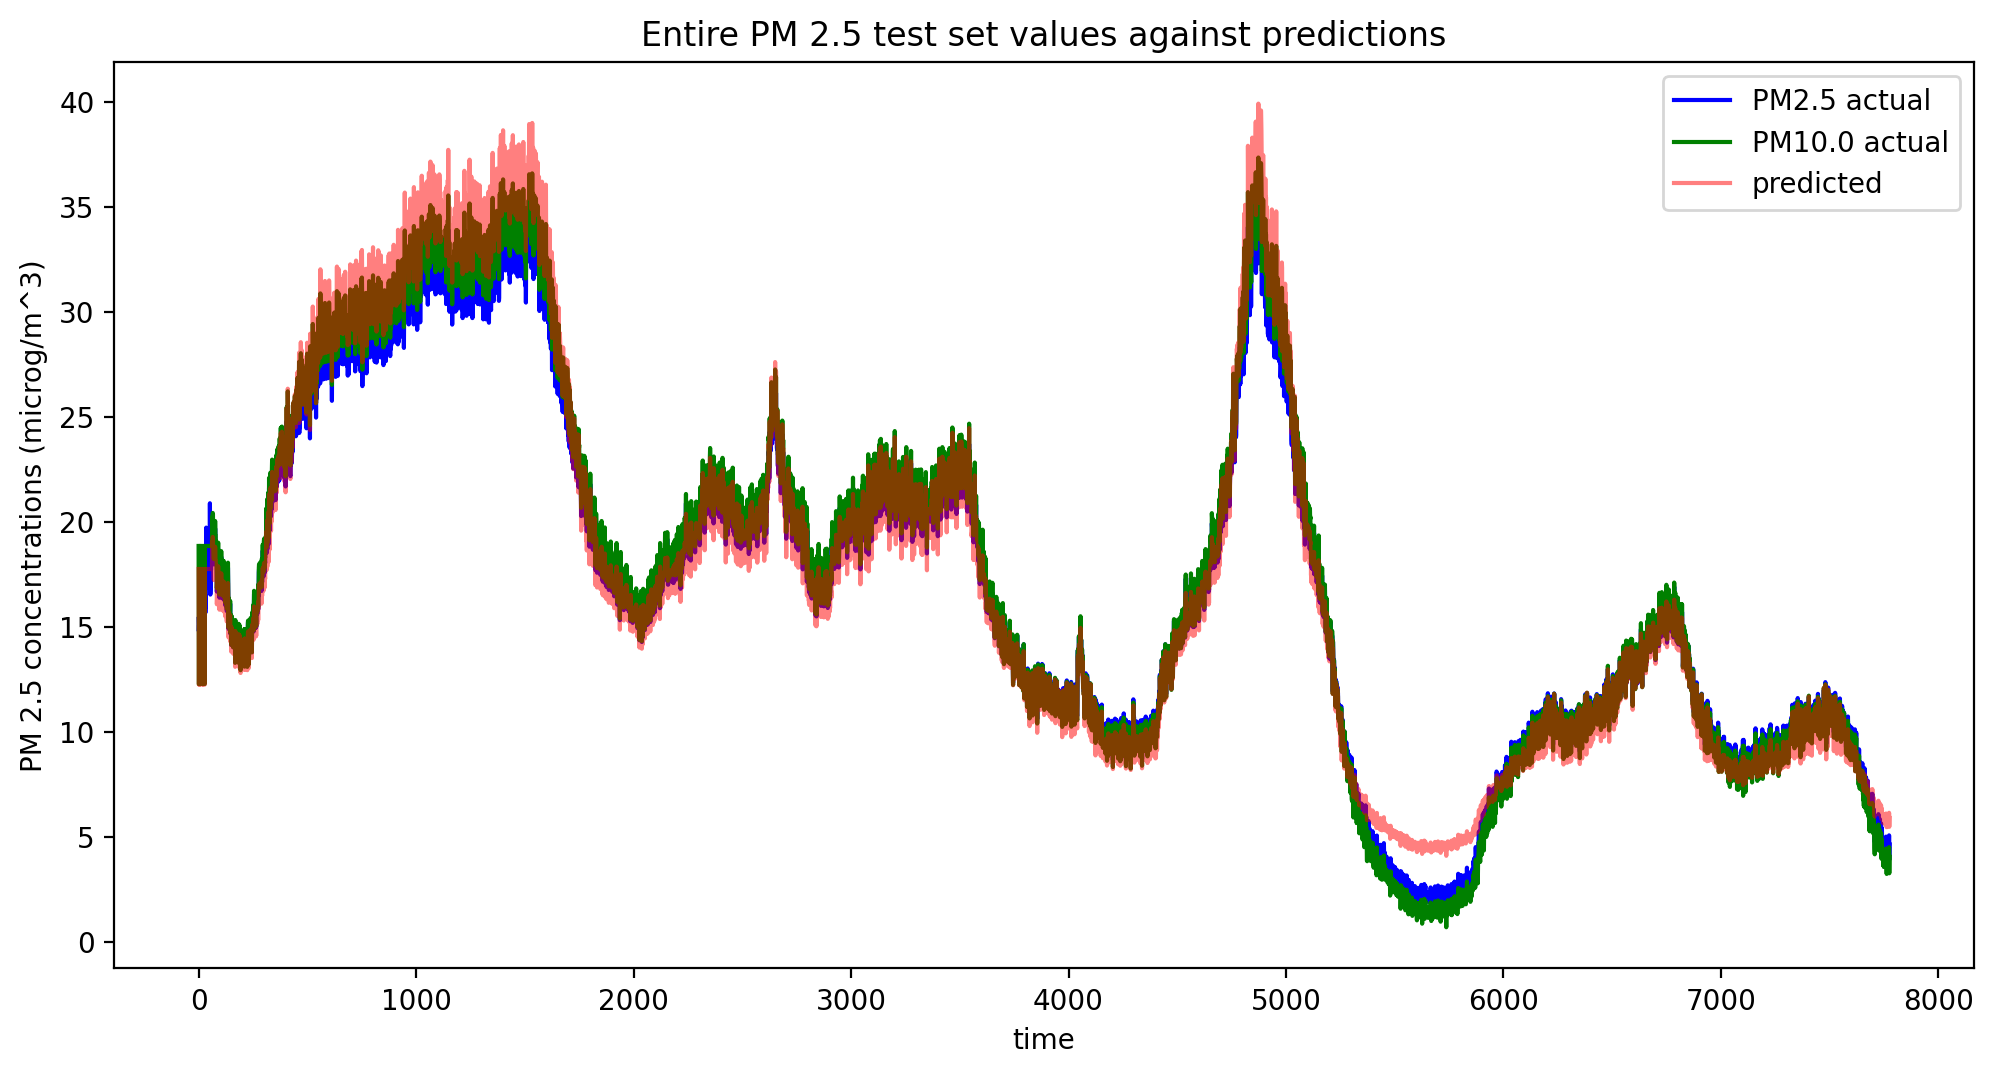

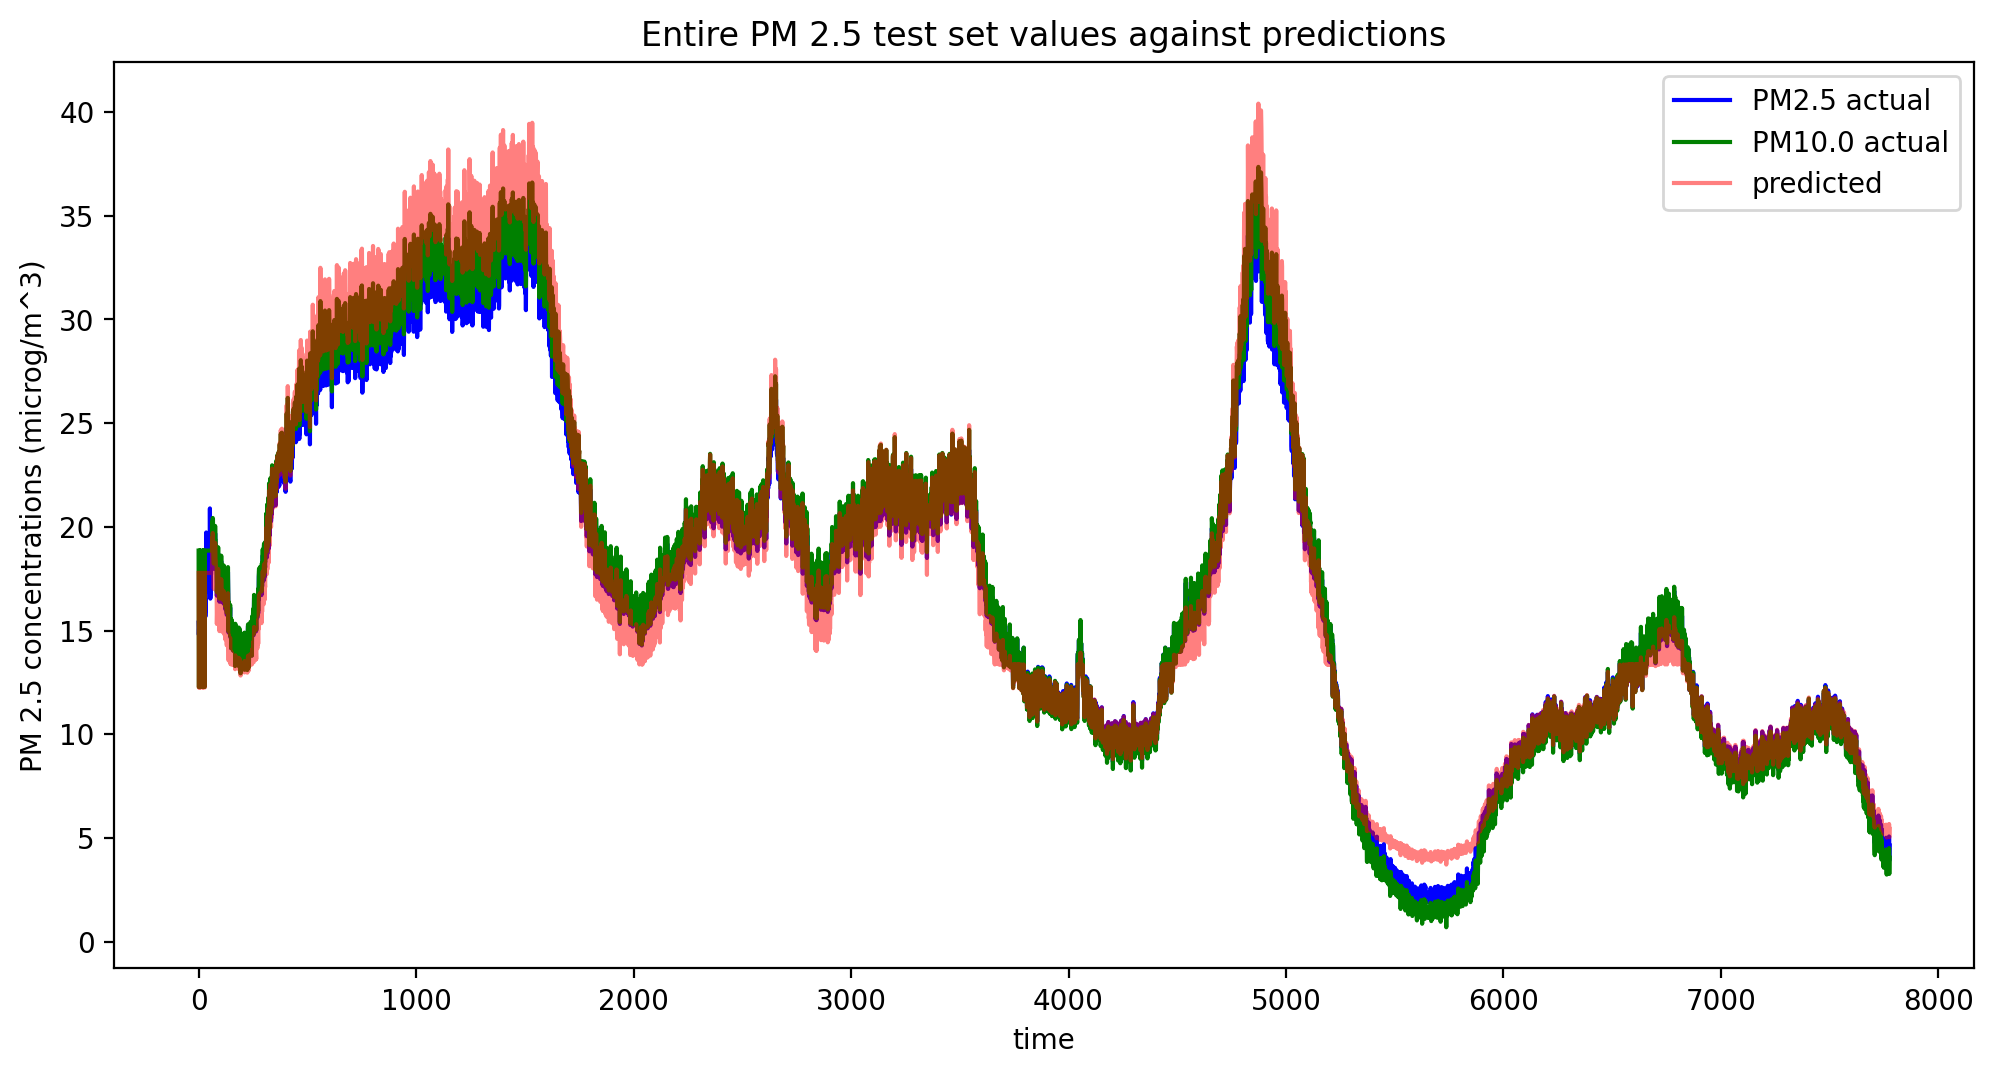

In [84]:
plt.figure(figsize=(12, 6), dpi=200)
plt.title("Entire PM 2.5 test set values against predictions")
plt.plot(np.arange(y_test.shape[0]), restore_PM25(y_test), color='b', label='PM2.5 actual')
plt.plot(np.arange(x_test.shape[0]), restore_PM25(x_test), color='g', label='PM10.0 actual')
#plt.plot(np.arange(x_test.shape[0]), x_test, color='g', label='Humity actual')
plt.plot(np.arange(y_test_pred.shape[0]), restore_PM25(y_test_pred), color='r', alpha=0.5, label='predicted')
plt.xlabel("time")
plt.ylabel("PM 2.5 concentrations (microg/m^3)")
plt.legend(loc='best')
plt.show()


K.clear_session()

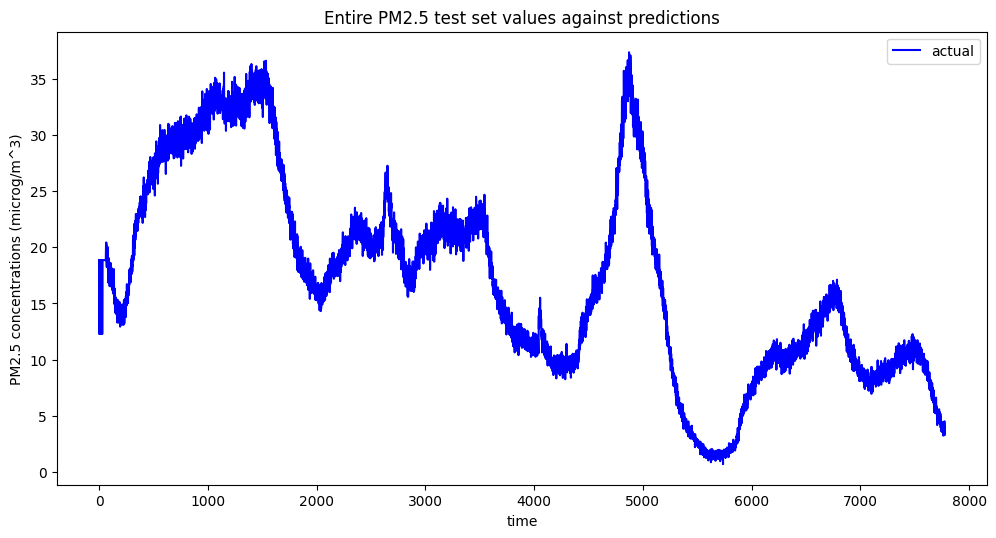

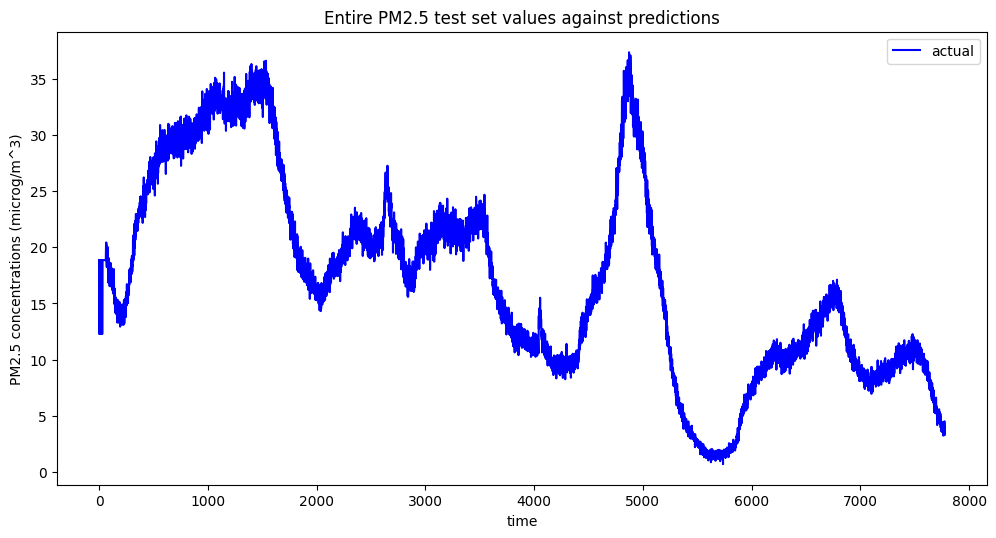

In [85]:
plt.figure(figsize=(12, 6), dpi=100)
plt.title("Entire PM2.5 test set values against predictions")
plt.plot(np.arange(x_test.shape[0]), restore_benzine(x_test), color='b', label='actual')
plt.xlabel("time")
plt.ylabel("PM2.5 concentrations (microg/m^3)")
plt.legend(loc='best')
plt.show()